# Import Cell

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.model_selection import train_test_split,cross_validate , GridSearchCV, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder , StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix , accuracy_score,recall_score,f1_score,precision_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
warnings.filterwarnings("ignore")

# Early EDA

In [2]:
df1 = pd.read_csv('data/Training Set Values.csv')
df2 = pd.read_csv('data/Training Set Labels.csv')
pd.set_option('display.max_columns',None)

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [4]:
df1.fillna('unknown',inplace=True)

Since all of our null values are objects, we filled them in as unknown for now so we can keep the whole dataset. We also need to join the labels and train set on ID.

In [5]:
# Here we add the status of the pumps into our main DF
dic = dict(zip(df2['id'],df2['status_group']))
df1['status'] = df1['id'].map(dic)

# Look at the distribution of our target values
df = df1.loc[df1['status'] == 'functional']
len(df) / len(df1)

non_sum = len(df1.loc[df1['status'] == 'non functional']) / len(df1) 
funciontal_sum = len(df) / len(df1) 
needs_repairs = 1-(non_sum+funciontal_sum)
needs_repairs
print(f'''Percent of functional: {round(funciontal_sum*100,2)}
Percent of non functional: {round(non_sum*100,2)}
Percent of pumps needing repairs: {round(needs_repairs*100,2)}
''')

Percent of functional: 54.31
Percent of non functional: 38.42
Percent of pumps needing repairs: 7.27



Since functional needs repairs only makes up 7% of our dataset, we have decided to convert this value to functional for easier modelling. This puts our target value at roughly a 62 to 38 percent distribution.

In [6]:
#binary_key = {'functional': 0,'functional needs repair': 0, 'non functional': 1}
#df1['status'].replace(binary_key, inplace=True)

Here we convert our functional / non functional to a binary value.

In [7]:

print(f'''Scheme name values: {df1['scheme_name'].unique()} 

Scheme management values: {df1['scheme_management'].unique()}''')
df1.drop(['num_private','public_meeting','scheme_name','id','funder','installer'],axis=1,inplace=True)

Scheme name values: ['Roman' 'unknown' 'Nyumba ya mungu pipe scheme' ... 'BL Nsherehehe'
 'Magati  gravity spri' 'Mtawanya'] 

Scheme management values: ['VWC' 'Other' 'unknown' 'Private operator' 'WUG' 'Water Board' 'WUA'
 'Water authority' 'Company' 'Parastatal' 'Trust' 'SWC' 'None']


Dropping columns we do not think that will not hold any value. 
Num_private is an undefined column with all zeroes.
Public meeting is defined as a True/False value in our column description and gives no indication to what it means.
id is simply the ID of the pump we used to join our dataframes on.
Scheme name seems to be similar to scheme management. 

In [8]:
source , source_class, source_type =df1['source'].unique() , df1['source_class'].unique() , df1['source_type'].unique()

print(f'''
Source Values: {source}

Source_class Values: {source_class}

Source_type Values: {source_type}''')

#Drop the columnd we will not use from our DF
df1.drop(['source_type'],axis=1,inplace=True)


Source Values: ['spring' 'rainwater harvesting' 'dam' 'machine dbh' 'other'
 'shallow well' 'river' 'hand dtw' 'lake' 'unknown']

Source_class Values: ['groundwater' 'surface' 'unknown']

Source_type Values: ['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake']


We have decided to keep Source Values and Source class Values as we think they will provide the most value to our model. The source type values column is a less specific version of the source values column.

In [9]:
extraction_type, extraction_type_group, extraction_type_class = df1['extraction_type'].unique() , df1['extraction_type_group'].unique() , df1['extraction_type_class'].unique()

print(f'''
Extraction Type Values: {extraction_type}

Extraction Type Group Values: {extraction_type_group}

Extraction Type Class: {extraction_type_class}''')

#Drop the columnd we will not use from our DF
df1.drop(['extraction_type_group','extraction_type_class'],inplace = True,axis=1)


Extraction Type Values: ['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'ksb' 'mono' 'windmill' 'afridev' 'other - rope pump' 'india mark iii'
 'other - swn 81' 'other - play pump' 'cemo' 'climax' 'walimi'
 'other - mkulima/shinyanga']

Extraction Type Group Values: ['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']

Extraction Type Class: ['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']


We have decided to keep the extraction type column as we think they will provide the most value to our model. The other two columns are a similar to the extraction values column but more vague.

In [10]:
len(df1['wpt_name'].unique())

37400

This column is the name of the water point which does not help us in our model. Subvillage, lga and ward are also listed as geographic information, but gives us no information we find that is useful. Region is also a more vague version of region id. 

In [11]:
#Drop selected columns
df1.drop(['wpt_name','subvillage','lga','ward','region'],axis=1,inplace=True)

In [12]:

print(f'''Waterpoint Type Group values:{df1['waterpoint_type_group'].unique()} , 

Waterpoint type values: {df1['waterpoint_type'].unique()}''')

df1.drop(['waterpoint_type_group'],axis=1,inplace=True)

Waterpoint Type Group values:['communal standpipe' 'hand pump' 'other' 'improved spring'
 'cattle trough' 'dam'] , 

Waterpoint type values: ['communal standpipe' 'communal standpipe multiple' 'hand pump' 'other'
 'improved spring' 'cattle trough' 'dam']


The waterpoint type column is a more specific version of the waterpoint type group. The group values column does not have the multiple standpipe option. We drop the waterpoint type group to use in our dataset. The date recorded column is just when the data was entered into the spreadsheet.

In [13]:
vals = df1['construction_year'].value_counts()
vals[:2]

0       20709
2010     2645
Name: construction_year, dtype: int64

For the construction year column, we have a little over 20,000 values with missing data.The next highest value is 2010, with 2645 wells! We will fill in the missing data with the median for the construction year, then make an age column for the pumps and drop the date recorded colum. We are assuming the age of the pump from the time the data was entered into the spreadsheet.

In [14]:
# Converts this column from boolean to string
df1['permit'] = df1['permit'].astype(str)

In [15]:
#makes a copy of df that has not been converted to binary values for target
df_non_binary = df1.copy()

# Apply the binary function to our target.
binary_key = {'functional': 0,'functional needs repair': 0, 'non functional': 1}
df1['status'].replace(binary_key, inplace=True)

In [16]:
# Some functions that may provide to be useful
def total_val_count(column):
    '''Creates a dictionary with all value counts in column'''
    counts = {}
    for i in df1[column]:
        counts[i] = counts.get(i, 0) + 1
    counts_sorted = dict(sorted(counts.items(), key=lambda item: item[1],reverse=True))
    return counts_sorted
    

def val_count_nf(column):
    '''Creates a dictionary with all non functioning pumps'''
    df_val = pd.DataFrame(df1.loc[(df1['status'] == 1)])
    counts = {}
    for i in df_val[column]:
        counts[i] = counts.get(i, 0) + 1
    counts_sorted = dict(sorted(counts.items(), key=lambda item: item[1],reverse=True))
    return counts_sorted

def addlabels(x,y,left,up):
    '''Add labels to a bar graph'''
    for i in range(len(x)):
        plt.text(i-left,y[i]+up,y[i])
        
def addlabelsbig(x,y,left,up):
    '''Add Big labels to a bar graph'''
    for i in range(len(x)):
        plt.text(i-left,y[i]+up,f'{y[i]}%',fontsize=20,color='black')
        
        
def percent_dict(column):
    
    '''Creates a dictionary that has highest percent of non functioning pumps'''
    
    percent= []
    lst = list(df1[column].unique())
    for val in lst:
        num_pumps = len(df1.loc[df1[column] == val])
        fail_pumps = len(df1.loc[(df1['status'] == 1) & (df1[column] == val)])
        percent.append(round((fail_pumps/num_pumps*100),2))     
    d = dict(zip(lst,percent))
    d_sorted = dict(sorted(d.items(), key=lambda item: item[1],reverse=True))
    return d_sorted

def visualize(dictionary,title=None):
    
    '''Creates Seaborn Barplot from Dictionary'''
    nums = list(dictionary.values())
    
    fig , ax = plt.subplots(figsize=(12,10))

    sns.barplot(x=list(dictionary.keys()),y=nums)
    ax.set_title(title,fontsize=15)
    ax.set_ylabel('Percent Non Functioning',fontsize=15);

def stack_it(column,title=None,addlabels=False):
    '''Returns Barplot showing total count of catgory type with percent of failure '''

    fig , ax= plt.subplots(nrows=1,ncols=1,figsize=(12,8))
    
    
    column_count = total_val_count(column)
    nums = list(column_count.values())[:5]
    top_5 = list(column_count.keys())[:5]
    transform = val_count_nf(column)
    num_failed = []
    for x in top_5:
        for y in transform.keys():
            if x == y:
                num_failed.append(transform[y])
    percent_failed = [round((i / j)*100,1) for i, j in zip(num_failed, nums)]
    
    ax.set_title(title,fontsize=15)
    sns.barplot(x=top_5,y=nums,alpha=.4,label='Total Count',color='orange')
    ax.set_ylabel('Total Count',fontsize=15)
    sns.barplot(x=top_5, y=num_failed,label='Amount Failed',color='orange')
    plt.xticks(rotation=45,fontsize=15)
    plt.yticks(fontsize=15)
    if addlabels:        
        addlabelsbig(top_5,percent_failed,.2,100);

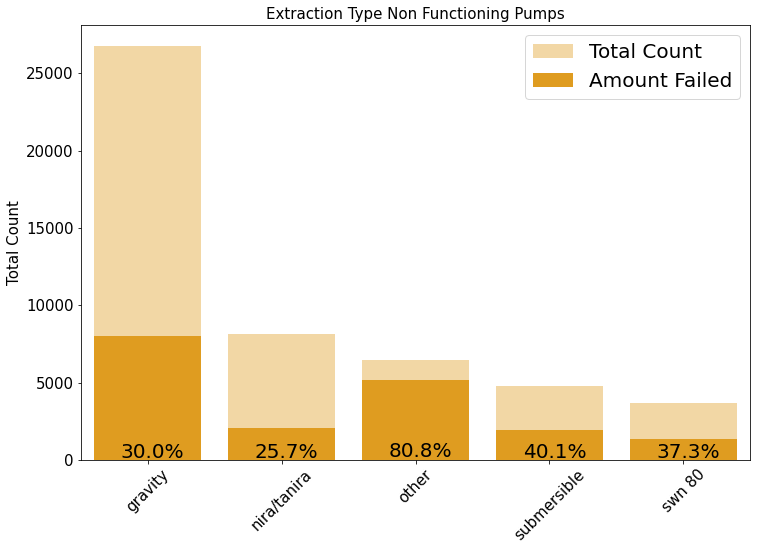

In [17]:
stack_it('extraction_type',title='Extraction Type Non Functioning Pumps',addlabels=True)
plt.legend(fontsize=20)
plt.savefig('images/Extraction Type Percent Failed');

In [18]:
val_count_nf('quantity')

{'enough': 9138,
 'dry': 6052,
 'insufficient': 5763,
 'seasonal': 1309,
 'unknown': 562}

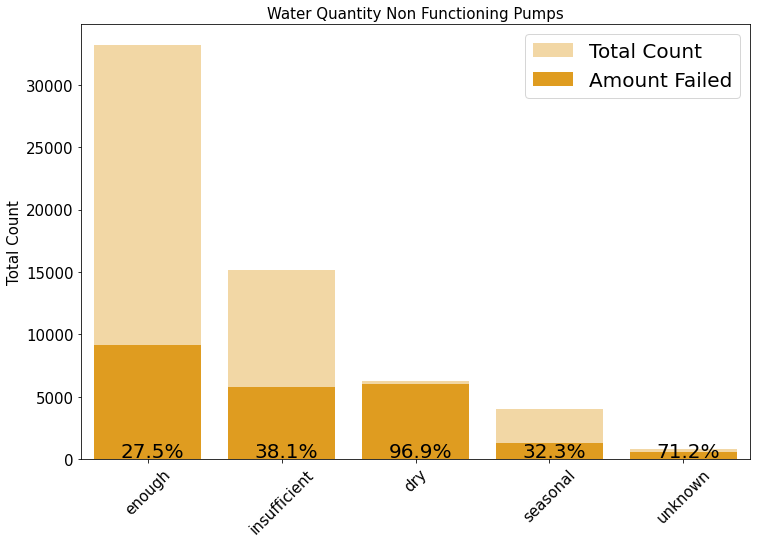

In [264]:
stack_it('quantity',title='Water Quantity Non Functioning Pumps',addlabels=True)
plt.legend(fontsize=20)
plt.savefig('images/Water Quantity Percent Failed');

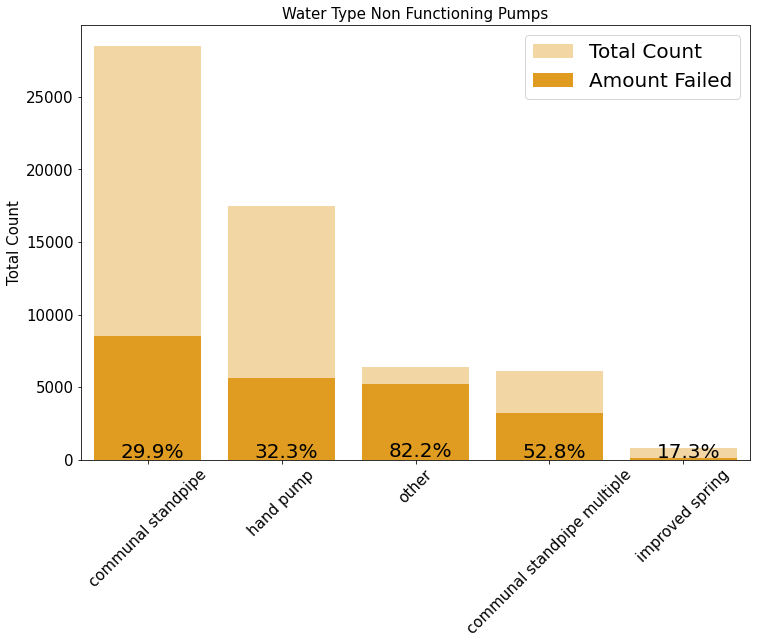

In [265]:
stack_it('waterpoint_type',title='Water Type Non Functioning Pumps',addlabels=True)
plt.legend(fontsize=20)
plt.savefig('images/Water Type Percent Failed');

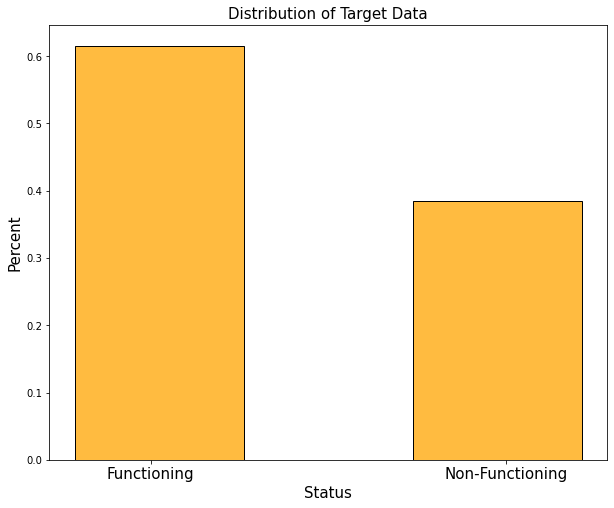

In [239]:
#Create visual for target data, easier for stakeholders to see
fig , ax = plt.subplots(figsize=(10,8))
sns.histplot(df1['status'],stat='probability',bins=3,color='orange')
plt.xticks([.15,.85],['Functioning','Non-Functioning'],fontsize=15)
ax.set_title('Distribution of Target Data',fontsize=15)
ax.set_xlabel('Status',fontsize=15)
ax.set_ylabel('Percent',fontsize=15);

In [242]:
#val_count_nf('extraction_type')
total_extraction = total_val_count('extraction_type')
total_extraction

{'gravity': 26780,
 'nira/tanira': 8154,
 'other': 6430,
 'submersible': 4764,
 'swn 80': 3670,
 'mono': 2865,
 'india mark ii': 2400,
 'afridev': 1770,
 'ksb': 1415,
 'other - rope pump': 451,
 'other - swn 81': 229,
 'windmill': 117,
 'india mark iii': 98,
 'cemo': 90,
 'other - play pump': 85,
 'walimi': 48,
 'climax': 32,
 'other - mkulima/shinyanga': 2}

In [243]:
df_new = val_count_nf('extraction_type')
df_new

{'gravity': 8031,
 'other': 5195,
 'nira/tanira': 2092,
 'submersible': 1911,
 'mono': 1654,
 'swn 80': 1368,
 'india mark ii': 873,
 'ksb': 686,
 'afridev': 528,
 'other - rope pump': 141,
 'other - swn 81': 102,
 'windmill': 60,
 'other - play pump': 55,
 'india mark iii': 53,
 'cemo': 36,
 'climax': 24,
 'walimi': 13,
 'other - mkulima/shinyanga': 2}

The highest number of failed extraction types seem to be gravity. Let's get a better look at how all of the pumps do. There are only 2 mkulima / shinyanga valuesto_dict we remove them. 

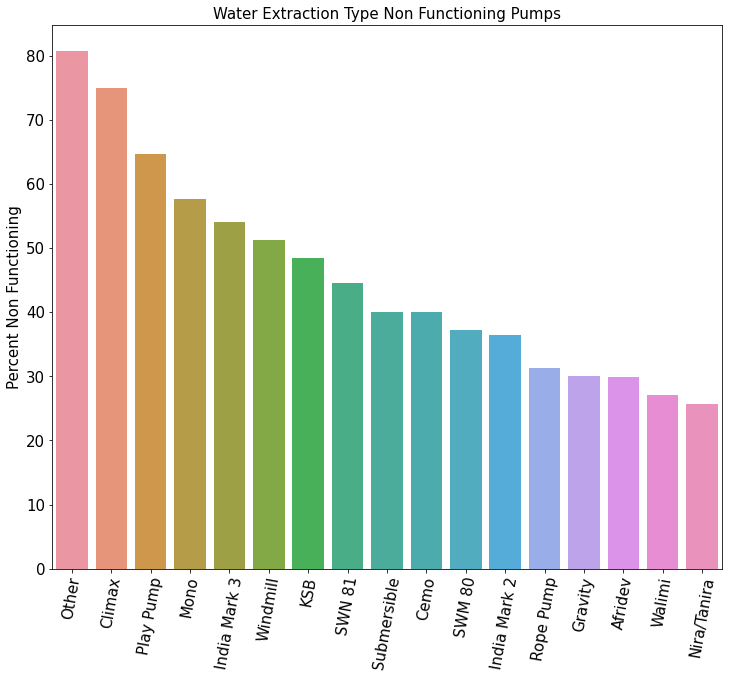

In [257]:

#Percent of failures for pumps:
extraction_type = percent_dict('extraction_type')
test = dict(sorted(extraction_type.items(), key=lambda item: item[1]))
#Remove the key with 2 values
del extraction_type['other - mkulima/shinyanga']
# Put our percentages in a list
nums = list(extraction_type.values())
#Create Custom Labels
labels = ['Other','Climax','Play Pump','Mono','India Mark 3','Windmill','KSB','SWN 81','Submersible','Cemo','SWM 80',
          'India Mark 2','Rope Pump','Gravity','Afridev','Walimi','Nira/Tanira']

fig , ax = plt.subplots(figsize=(12,10))

sns.barplot(x=labels,y=nums)
ax.set_title('Water Extraction Type Non Functioning Pumps',fontsize=15)
plt.xticks(rotation=80,fontsize=15)
plt.yticks(fontsize=15)
ax.set_ylabel('Percent Non Functioning',fontsize=15);
#addlabels(labels,nums,.4,.3);

#plt.savefig('images/Water Extraction Type')

The highest percent of failures seem to come from extraction types  Climax, play pumps and Mono extraction types. So while gravity has a high number of failed extraction types, it ranks low in overall failures. It would be very interesting if we could ID the 'Other' category to get more information on what extraction types would cause more non functioning pumps.

In [254]:
val_count_nf('water_quality')

{'soft': 18154,
 'salty': 2411,
 'unknown': 1577,
 'milky': 352,
 'coloured': 190,
 'salty abandoned': 93,
 'fluoride': 36,
 'fluoride abandoned': 11}

Here we see soft water has the highest number of failures. This looks like the number is high because it is also the most common water type. We would expect water with higher solid contents (such as saltwater) to have a high percent of failures because of the wear and tear caused by the solids in the water. 

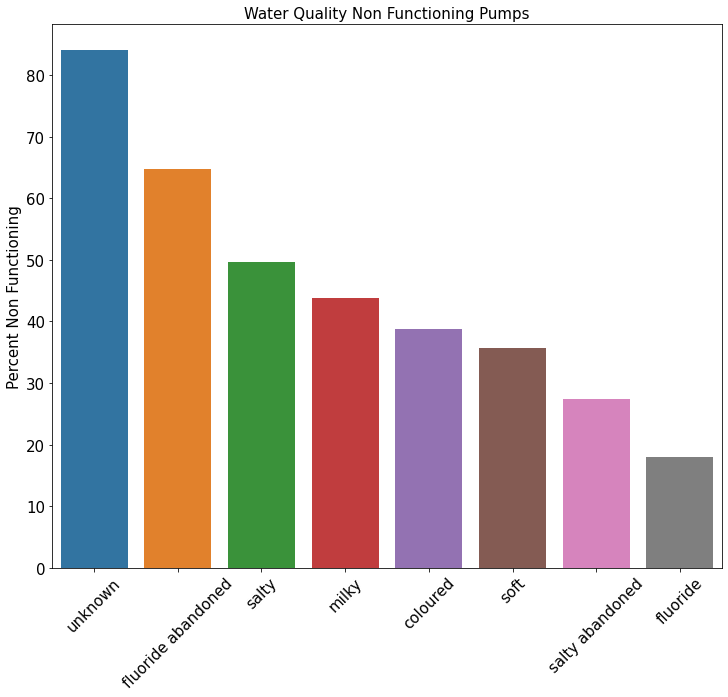

In [28]:
water_quality = percent_dict('water_quality')
visualize(water_quality,title='Water Quality Non Functioning Pumps')
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15);


Just as we thought, soft water is in the lower percentage of failures. Saltwater pumps are in the higher percentage range for failures, while abondoned saltwater pumps have a lower failure rate. Perhaps the failure rate is lower for the abandoned saltwater pumps because they no longer see usage. Were they abandoned because the pumps quit working or because the water source is saltwater? With such a high amount of abandoned salt pumps (339 total, 93 pumps non functioning), one could assume the pump was abandoned because salt water is not valuable. 

Unknown water types take the lead for failures. It would be interesting to see the solid content percent of those unknown water types, as we think more solids in the water leads to more failures. Other things (like flow rates) would affect the failures also. The faster the solids move in water, the more damage they will do to pumps!  

In [29]:
len(df1.loc[df1['water_quality'] == 'salty abandoned']) , len(df1.loc[(df1['status'] == 1) & (df1['water_quality'] == 'salty abandoned')])

(339, 93)

In [30]:
len(df1.loc[df1['water_quality'] == 'fluoride abandoned']) , len(df1.loc[(df1['status'] == 1) & (df1['water_quality'] == 'fluoride abandoned')])

(17, 11)

There are only 17 abondoned fluoride wells, with 11 of them not working. This is the reason the percentage is so high.

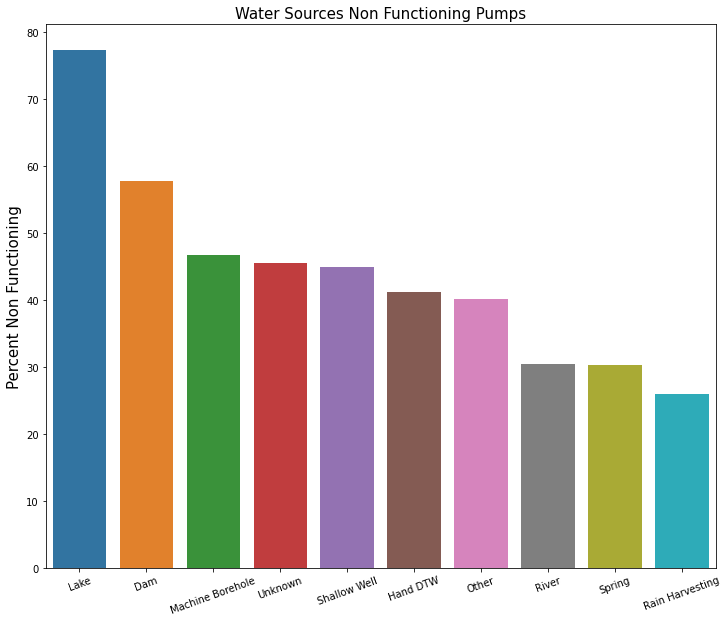

In [31]:
source = percent_dict('source')
visualize(source,title='Water Sources Non Functioning Pumps')
plt.xticks([0, 1, 2, 3 ,4 ,5, 6, 7, 8, 9], ['Lake','Dam','Machine Borehole','Unknown','Shallow Well','Hand DTW','Other','River','Spring','Rain Harvesting'],
    rotation=20);


Lakes and dams seem to have the Highest percent of pump failures followed by dams then boreholes. Lakes could have a high failure rate because they see the most usage along with dams. 

# Model Development

In [33]:
#Prepare function to get metrics
def metrics(y_test,y_preds):
    return print(f'''Recall Score: {recall_score(y_test,y_preds)}
Precision Score: {precision_score(y_test,y_preds)}
Accuracy Score:{accuracy_score(y_test,y_preds)}
F1 Score: {f1_score(y_test,y_preds)}
Matrix: 
{confusion_matrix(y_test,y_preds)}''')

In [34]:
# Create a dummy model for starting point
X = df_non_binary.drop(['status'],axis=1)
y = df_non_binary['status']

dummy_model = DummyClassifier(strategy="most_frequent")

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=42,stratify=y)

binary_key = {'functional': 0,'functional needs repair': 0, 'non functional': 1}
y_train.replace(binary_key, inplace=True)


cv_results = cross_validate(dummy_model, X_train, y_train, return_train_score=True)


print(f'''Dummy Accuracy Score: {cv_results['test_score'].mean()}''')

Dummy Accuracy Score: 0.6157575757575758


# KNN Model

In [286]:
# Prepare for testing
X = df_non_binary.drop(['status'],axis=1)
y = df_non_binary['status']

In [287]:
#Split our data. We stratify Y to make sure the split is balanced.
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=42,stratify=y)

binary_key = {'functional': 0,'functional needs repair': 0, 'non functional': 1}
y_train.replace(binary_key, inplace=True)
y_test.replace(binary_key,inplace=True)

In [288]:
# Find median of column
median_no_zero = int(X_train[X_train['construction_year'] > 0]['construction_year'].median())
# Find rows where construction year is zero and fill in with median , which is year 2000
X_train.loc[(X_train['construction_year'] == 0),'construction_year'] = median_no_zero
X_train.loc[(X_train['construction_year'] > X_train['date_recorded'].str[:4].astype(int)),'construction_year'] = median_no_zero
#Subtract construction year from date recorded
X_train['age']=X_train['date_recorded'].str[:4].astype(int) - X_train['construction_year']
#Drop Date recorded
X_train.drop('date_recorded',axis=1,inplace=True)

In [289]:
#Apply 
median_no_zero = int(X_test[X_test['construction_year'] > 0]['construction_year'].median())
# Find rows where construction year is zero and fill in with median , which is year 2000
X_test.loc[(X_test['construction_year'] == 0),'construction_year'] = median_no_zero
X_test.loc[(X_test['construction_year'] > X_test['date_recorded'].str[:4].astype(int)),'construction_year'] = median_no_zero
#Subtract construction year from date recorded
X_test['age']=X_test['date_recorded'].str[:4].astype(int) - X_test['construction_year']
#Drop Date recorded
X_test.drop('date_recorded',axis=1,inplace=True)

In [290]:
#Split columns into number and objects
categorical_cols = X_train.select_dtypes('object')
numerical_cols = X_train.select_dtypes(exclude=['object'])

#Prepare pipeline steps for each of the column types
categorical_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])
numerical_pipeline = Pipeline(steps=[('ss', StandardScaler())])

# col_trans = ColumnTransformer(transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
#                               remainder='passthrough')

# Set up column transformer to plug into our pipeline
trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, numerical_cols.columns),
    ('categorical', categorical_pipeline, categorical_cols.columns)
])

# Set up our pipeline and use a KNN model first.
base_pipline = Pipeline(steps=[('trans', trans),
                              ('model', KNeighborsClassifier())])

cv = cross_validate(base_pipline, X_train, y_train, return_train_score=True)


In [291]:
print(f'''Mean of Test Scores:{cv['test_score'].mean()}
Mean of Training Scores: {cv['train_score'].mean()}''')

Mean of Test Scores:0.8254320987654321
Mean of Training Scores: 0.8767340067340067


Our model has good bias for a first model, which we will consider low. Our variance is a little high. Our model is overfit.

In [295]:
# Use GridSearch in order to find the best parameters for our model

grid= {'model__n_neighbors': [5,7,11,15,21],
      'model__weights': ['distance','uniform'],
      }

gs = GridSearchCV(base_pipline,grid,cv=3)
gs.fit(X_train,y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'construction_year', 'age'],
      dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown=...
                                                                         Index(['basin', 're

In [297]:
# Fit our pipeline with best parameters and see what they are
base_pipline.fit(X_train,y_train)
gs.best_params_ , gs.best_score_ 


({'model__n_neighbors': 21, 'model__weights': 'distance'}, 0.8280808080808081)

In [301]:
cv_predict_KNN = cross_val_predict(base_pipline,X_train,y_train)

In [302]:
# Look at our scoring metrics and confusion matrix
knn_metrics = metrics(cv_predict_KNN,y_train)

Recall Score: 0.8010700702636498
Precision Score: 0.7259609767496202
Accuracy Score:0.8254320987654321
F1 Score: 0.7616683521804419
Matrix: 
[[24346  4691]
 [ 3086 12427]]


Gridsearch improved our accuracy score by a small amount. The best number of neighbors is 21 and distance our best weight. We still have a moderate amount of variance in our model.

# Logistic Model

Here we will try another model, going with logistic this time. We will follow a similar process as last time with pipeline. We will change the model type and the hyper parameters in grid search.

In [304]:
X = df_non_binary.drop(['status'],axis=1)
y = df_non_binary['status']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=42,stratify=y)

binary_key = {'functional': 0,'functional needs repair': 0, 'non functional': 1}
y_train.replace(binary_key, inplace=True)

In [305]:

categorical_cols = X_train.select_dtypes('object')
numerical_cols = X_train.select_dtypes(exclude=['object'])

categorical_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

numerical_pipeline = Pipeline(steps=[('ss', StandardScaler())])

trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, numerical_cols.columns),
    ('categorical', categorical_pipeline, categorical_cols.columns)
])

# Change model type and hyper parameters

base_pipline = Pipeline(steps=[('trans', trans),
                              ('model', LogisticRegression(random_state=42))])


grid = {'model__C' : [ 1, 50],
       'model__max_iter' : [100, 200],
       'model__class_weight': [None, 'balanced', 0.25],
       'model__tol' : [0.01, 0.1]}

gs = GridSearchCV(base_pipline, grid, cv=3)


In [306]:
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'construction_year'],
      dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignor...
       'extraction_type', 'management', 'management_group', 'payment',
       'payment_type',

In [313]:
gs.best_params_ , gs.best_score_ 

({'model__C': 1,
  'model__class_weight': None,
  'model__max_iter': 100,
  'model__tol': 0.01},
 0.793625140291807)

Our score is a little worse than the KNN model.

In [307]:
cv = cross_validate(base_pipline, X_train, y_train, return_train_score=True)
print(f'''Train Score: {cv['train_score'].mean()}  
Test Score: {cv['test_score'].mean()}''')

Train Score: 0.7981762065095398  
Test Score: 0.7931762065095398


This model does have low variance with similar bias to our KNN model. Our overfitting problem is reduced but we sacrificed some accuracy for it.

In [ ]:
y_pred = cros_val_predict()
metrics()

In [315]:
cv_predict_log = cross_val_predict(base_pipline,X_train,y_train)

In [316]:
log_metrics = metrics(cv_predict_log,y_train)

Recall Score: 0.8130544993662865
Precision Score: 0.599602757331464
Accuracy Score:0.7931762065095398
F1 Score: 0.6902024073700491
Matrix: 
[[25072  6854]
 [ 2360 10264]]


This model has low bias and low variance. This is not a bad model overall, but we will explore other model types to see if accuracy can be improved.

# Random Forest Model

In [483]:
#We repeat the same steps as above
X = df_non_binary.drop(['status'],axis=1)
y = df_non_binary['status']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=42,stratify=y)

binary_key = {'functional': 0,'functional needs repair': 0, 'non functional': 1}
y_train.replace(binary_key, inplace=True)

In [485]:
median_no_zero = int(X_train[X_train['construction_year'] > 0]['construction_year'].median())
# Find rows where construction year is zero and fill in with median , which is year 2000
X_train.loc[(X_train['construction_year'] == 0),'construction_year'] = median_no_zero

In [486]:
categorical_cols = X_train.select_dtypes('object')
numerical_cols = X_train.select_dtypes(exclude=['object'])

In [487]:
trans = ColumnTransformer(transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_cols.columns)],
remainder='passthrough')

In [488]:
model_pipe = Pipeline(steps=[
    ('trans', trans),
    ('rfc', RandomForestClassifier(random_state=42)
])

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' on line 3 (<ipython-input-488-e26a7aeefa81>, line 4)

In [321]:
grid = [{'rfc__n_estimators':[100],
         'rfc__criterion':['gini', 'entropy'],
         'rfc__max_depth':[None,3,5],
         'rfc__min_samples_split':[2,5,10],
         'rfc__min_samples_leaf':[1,3,5,7]}]

In [322]:
gs_pipe = GridSearchCV(estimator=model_pipe, param_grid=grid, cv=3, return_train_score=True)

In [323]:
gs_pipe.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['date_recorded', 'basin', 'recorded_by', 'scheme_management', 'permit',
       'extraction_type', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_class', 'waterpoint_type'],
      dtype='object'))])),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             param_grid=[{'rfc__criterion': ['gini', 'entropy'],
                          'rfc__max_depth': [None, 3, 5],
            

In [324]:
gs_pipe.best_score_ , gs_pipe.best_params_

(0.8527721661054994,
 {'rfc__criterion': 'entropy',
  'rfc__max_depth': None,
  'rfc__min_samples_leaf': 1,
  'rfc__min_samples_split': 5,
  'rfc__n_estimators': 100})

This has given us our best score yet. We will plug these parameters into the pipeline and do further investigation.

model_pipe = Pipeline(steps=[
    ('trans', trans),
    ('rfc', RandomForestClassifier(random_state=42,criterion='entropy',max_depth=None,min_samples_leaf=1,min_samples_split=5,n_estimators=100))
])

In [331]:
model_pipe.fit(X_train,y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['date_recorded', 'basin', 'recorded_by', 'scheme_management', 'permit',
       'extraction_type', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_class', 'waterpoint_type'],
      dtype='object'))])),
                ('rfc',
                 RandomForestClassifier(criterion='entropy',
                                        min_samples_split=5,
                                        random_state=42))])

In [332]:
cv_results_RF = cross_validate(model_pipe, X_train, y_train, return_train_score=True)

In [335]:
print(f'''Train Score: {cv_results_RF['train_score'].mean()}  
Test Score: {cv_results_RF['test_score'].mean()}''')

Train Score: 0.9618462401795735  
Test Score: 0.8559820426487093


This is a high variance low bias model, but it has given us our best predictive power yet.

In [336]:
y_pred = cross_val_predict(model_pipe,X_train,y_train)
metrics(y_train,y_pred)

Recall Score: 0.7569225376796355
Precision Score: 0.8517617670260321
Accuracy Score:0.8559820426487094
F1 Score: 0.8015465511908445
Matrix: 
[[25177  2255]
 [ 4161 12957]]


This model has more false positives than our other models. This seems like a good model to explore further.

# Fixing Overfitting

In [450]:
# Find what features are best
classifier = model_pipe.named_steps['rfc']
vals = classifier.feature_importances_
names = trans.named_transformers_["ohe"].get_feature_names()

cols = dict(zip(names,vals))
cols_sorted = dict(sorted(cols.items(), key=lambda item: item[1],reverse=True))
#cols_sorted

Wow that is alot of columns! Let's look at where we have the value dry in our dataframe. 

In [464]:
df_non_binary.columns

Index(['amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude',
       'basin', 'region_code', 'district_code', 'population', 'recorded_by',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'status'],
      dtype='object')

In [465]:
df_non_binary['quantity'].unique() ,df_non_binary['quantity_group'].unique()

(array(['enough', 'insufficient', 'dry', 'seasonal', 'unknown'],
       dtype=object),
 array(['enough', 'insufficient', 'dry', 'seasonal', 'unknown'],
       dtype=object))

Well these 2 columns seem to be clones of each other, so lets get rid of one! Will also get rid of some other columns that may make a difference.

In [466]:
df_non_binary.drop(['quantity_group','date_recorded','management_group','payment','permit','management','recorded_by'],axis=1,inplace=True)

# Next Model Iteration

In [502]:
X = df_non_binary.drop(['status','management','recorded_by'],axis=1)
y = df_non_binary['status']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=42,stratify=y)

binary_key = {'functional': 0,'functional needs repair': 0, 'non functional': 1}
y_train.replace(binary_key, inplace=True)

In [503]:
# Insert median for construction year
median_no_zero = int(X_train[X_train['construction_year'] > 0]['construction_year'].median())
# Find rows where construction year is zero and fill in with median , which is year 2000
X_train.loc[(X_train['construction_year'] == 0),'construction_year'] = median_no_zero

categorical_cols = X_train.select_dtypes('object')
numerical_cols = X_train.select_dtypes(exclude=['object'])

In [504]:
trans = ColumnTransformer(transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_cols.columns)],
remainder='passthrough')

In [505]:
model_pipe2 = Pipeline(steps=[
    ('trans', trans),
    ('rfc', RandomForestClassifier(random_state=42,criterion='entropy',max_depth=None,min_samples_leaf=1,min_samples_split=5,n_estimators=100))
])

In [506]:
model_pipe2.fit(X_train,y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['basin', 'scheme_management', 'extraction_type', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'source', 'source_class',
       'waterpoint_type'],
      dtype='object'))])),
                ('rfc',
                 RandomForestClassifier(criterion='entropy',
                                        min_samples_split=5,
                                        random_state=42))])

In [507]:
cv_results_RF = cross_validate(model_pipe2, X_train, y_train, return_train_score=True)

In [508]:
print(f'''Train Score: {cv_results_RF['train_score'].mean()}  
Test Score: {cv_results_RF['test_score'].mean()}''')

Train Score: 0.9678563411896745  
Test Score: 0.8545679012345679


In [510]:
y_pred = cross_val_predict(model_pipe2,X_train,y_train)
metrics(y_train,y_pred)

Recall Score: 0.7580324804299567
Precision Score: 0.8473845751975446
Accuracy Score:0.8545679012345679
F1 Score: 0.800222009805433
Matrix: 
[[25095  2337]
 [ 4142 12976]]


Well that didn't seem to work at all. Our overfitting slightly increased while our accuracy slightly decreased!

In [497]:
classifier = model_pipe.named_steps['rfc']
vals = classifier.feature_importances_
names = trans.named_transformers_["ohe"].get_feature_names()
cols = dict(zip(names,vals))
cols_sorted = dict(sorted(cols.items(), key=lambda item: item[1],reverse=True))
cols_sorted

{'x8_dry': 0.10313593672281049,
 'x3_other': 0.03445097211501374,
 'x11_other': 0.030206916660702226,
 'x8_enough': 0.024317290927315657,
 'x5_never pay': 0.01344458364161705,
 'x8_insufficient': 0.013430243858378788,
 'x11_communal standpipe': 0.012494553864501028,
 'x3_gravity': 0.009625682846265958,
 'x11_hand pump': 0.008854158731501107,
 'x3_nira/tanira': 0.008789493929155298,
 'x4_vwc': 0.008116593923744841,
 'x9_spring': 0.007864530123237434,
 'x11_communal standpipe multiple': 0.007287156561943943,
 'x2_VWC': 0.006995352641234887,
 'x9_machine dbh': 0.006554544182779793,
 'x5_per bucket': 0.006355092924862964,
 'x5_unknown': 0.006220252519033165,
 'x7_unknown': 0.006193333602680702,
 'x8_seasonal': 0.006138488521071643,
 'x5_monthly': 0.005782560527824005,
 'x9_shallow well': 0.005674726201556035,
 'x0_Internal': 0.0055449787574670464,
 'x10_surface': 0.0052009975317400805,
 'x10_groundwater': 0.00488249084501246,
 'x6_unknown': 0.004844794733536024,
 'x3_submersible': 0.004285

Well that didn't seem to work at all. Our overfitting slightly increased while our accuracy slightly decreased!